---
title: Correlation of Enformer CAGE predictions on rn7 reference genome and measured gene expression in Br rats
author: Sabrina Mi
date: 8/23/2023
description: Pearson correlation for across genes is 0.45 and Spearman correlation is 0.76. 

---

We ran Enformer across all rat genes and quantified expression in brain tissue. Our numbers, 0.45 pearson's correlation and 0.76 spearman's correlation, are very exciting. Although Enformer is optimized to predict gene expression in humans, we see a very strong performance in rats. In GTEx, Enformer predicts reference gene expression with 0.54 pearson's correlation and 0.79 spearman's correlation, while in GUEVADIS (LCL tissue), we see 0.20 pearson's and 0.77 spearman's.

## Concatenate Predictions

We start with concatenating our predictions into separate files by chromosome number, firstly because our predictions are currently split between two directories and secondly, by grouping intervals together by chromosome, we can parallelize computing gene expression.

In [2]:
import glob
import os
import h5py
import parsl
from parsl import python_app
from parsl.configs.local_threads import config
parsl.load(config)


In [3]:
output_dir = "/home/s1mi/Br_predictions/predictions_folder/reference_Br_all_genes"
chr_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "X"]

In [4]:
@python_app
def concatenate_predictions_by_chromosome(predictions_dir, chr, output_dir):
    output_path = os.path.join(output_dir, f"chr{chr}_predictions.h5")
    with h5py.File(output_path, "a") as output_file:
        files = glob.glob(f"{predictions_dir}/chr{chr}_*_predictions.h5")
        for file in files:
            interval = os.path.basename(file).replace("_predictions.h5", "")
            with h5py.File(file, "r") as input_file:
                output_file[interval] = input_file[interval][()]
            

In [5]:
## concatenate files in first prediction run
predictions_dir = f"{output_dir}/predictions_2023-08-16/enformer_predictions/reference_Br/haplotype0"
app_futures = []
for chr in chr_list:
    app_futures.append(concatenate_predictions_by_chromosome(predictions_dir, chr, output_dir))
exec_futures = [q.result() for q in app_futures]

In [13]:
## concatenate files in second prediction run
predictions_dir = f"{output_dir}/predictions_2023-08-29/enformer_predictions/reference_Br/haplotype0"
app_futures = []
for chr in chr_list:
    app_futures.append(concatenate_predictions_by_chromosome(predictions_dir, chr, output_dir))

exec_futures = [q.result() for q in app_futures]

Second prediction folder done


## Compare Predicted and Observed

In [11]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import parsl
from parsl import python_app
from parsl.configs.local_threads import config
parsl.load(config)

In [4]:
project_dir = "/home/s1mi/Br_predictions/predictions_folder/reference_Br_all_genes"
chr_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "X"]
rn7_annot = pd.read_csv('/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt', sep ='\t')
gene_dict = rn7_annot.groupby('chromosome')['geneId'].apply(list).to_dict()

/tmp/ipykernel_89896/1953959868.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  rn7_annot = pd.read_csv('/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt', sep ='\t')


In [5]:
## filter genes to chr1-20 and X and make chr all strings
gene_dict = {str(key): value for key, value in gene_dict.items() if str(key) in chr_list}

In [6]:
tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')
mean_tpm = tpm.iloc[:,3:].mean(axis=1)
mean_tpm.name = 'observed'

/tmp/ipykernel_89896/417279503.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')


In [15]:
## Function to put CAGE predictions in list (in the same order as gene list by chromosome)
@python_app
def query_genes(chr):
    gene_list = gene_dict[chr]
    with h5py.File(f"{project_dir}/chr{chr}_predictions.h5", "r") as file:
        for gene in gene_list:
            interval = f"chr{chr}_{rn7_annot.loc[gene]['tss']}_{rn7_annot.loc[gene]['tss']}"
            bins = file[interval][446:450, 4980]
            CAGE_predictions[chr].append(np.average(bins))

In [19]:
rn7_annot.set_index("geneId", inplace=True)
CAGE_predictions = {chr: [] for chr in chr_list}
app_futures = []
## Collect CAGE predictions in parallel across genes
for chr in chr_list:
    app_futures.append(query_genes(chr))
## Wait for all chromosomes to finish
exec_futures = [q.result() for q in app_futures]

In [21]:
merged_dict = {}
for chr in chr_list:
    merged_dict[chr] = pd.DataFrame(index=gene_dict[chr])
    merged_dict[chr]['predicted'] = CAGE_predictions[chr]
    merged_dict[chr]['observed'] = mean_tpm.loc[gene_dict[chr]]

In [23]:
all_genes = pd.concat(merged_dict.values())
#all_genes.to_csv("/home/s1mi/enformer_rat_data/output/rn7_reference_predicted_vs_observed_expression.csv")

In [2]:
import pandas as pd
all_genes = pd.read_csv("/home/s1mi/enformer_rat_data/output/rn7_reference_predicted_vs_observed_expression.csv", index_col=0)
print("Pearson Correlation:")
all_genes.corr(method="pearson")

Pearson Correlation:


,predicted,observed
predicted,1.000000,0.452596
observed,0.452596,1.000000


In [3]:
print("Spearman Correlation:")
all_genes.corr(method="spearman")

Spearman Correlation:


,predicted,observed
predicted,1.000000,0.759705
observed,0.759705,1.000000


Correlation across all rn7 genes: 0.7597054021798328


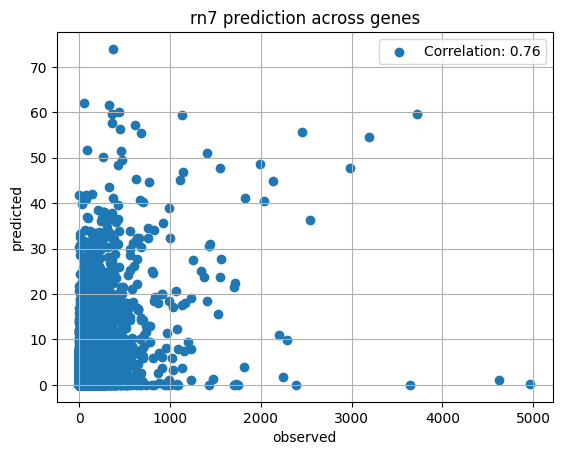

In [6]:
import matplotlib.pyplot as plt
corr = all_genes.corr(method="spearman").iloc[0,1]
print("Correlation across all rn7 genes:", corr)
plt.scatter(all_genes['observed'], all_genes['predicted'], label=f'Correlation: {corr:.2f}')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title("Enformer prediction across rat genes")
plt.legend()
plt.grid(True)
plt.show()